In [91]:
BASE_FOLDER="..//test//testdata//nmr/" # folder with the spec
RECURSIVE=True # check all subfolders of BASE_FOLDER
MIN_PEAK_HEIGHT=0.02 #realtiv to maximum
MIN_PEAK_DISTANCE=0.1 # before mergine to one peak
MAX_PEAK_WIDTH=2

REF_PEAK=2.5 
REF_PEAK_AREA=1

STORE_CSV=True # for every spec
STORE_IMG=True # for every spec

In [111]:
from autochem.spectra.nmr.reader import read_nmr,NMRReadError
from autochem.spectra.nmr.utils import zoom
from autochem.utils.corrections import norm_data
from autochem.utils.corrections.baseline import rubberband_correction
from autochem.utils.signals.peak_detection import find_peaks, peak_integration, get_reference_peak
import matplotlib.pyplot as plt
import numpy as np

def work_path(path):
    try:
        data, udict = read_nmr(path, preprocess=True)
        print("read '{}' as {}".format(path,udict["datatype"]))
    except NMRReadError as e:
        return False
    
    ppm=udict["ppm_scale"]
    
    data, corr_data = rubberband_correction(ppm,data)

    data, normed = norm_data(data)

    #plt.plot(ppm,data)
    #plt.show()
    #plt.close()

    peaks, peak_data = find_peaks(y=data, x=ppm, min_peak_height=MIN_PEAK_HEIGHT, rel_height=0.001,
                                 max_width=MAX_PEAK_WIDTH
                                 )
    #print(peak_data)
    #print(peak_data["peak_left_border"].min(),peak_data["peak_right_border"].max())
    #print(ppm[peak_data["peak_left_border"].min()],
    #        ppm[peak_data["peak_right_border"].max()])
    data, ppm = zoom(
            data,
            ppm,
            ppm[peak_data["peak_left_border"].min()],
            ppm[peak_data["peak_right_border"].max()],
        )
    
    data, corr_data = rubberband_correction(ppm,data)

    data, normed = norm_data(data)

    
    peaks, peak_data = find_peaks(y=data, x=ppm, min_peak_height=MIN_PEAK_HEIGHT,
                                  rel_height=0.01, rel_prominence=0.4,min_distance=MIN_PEAK_DISTANCE,
                                  center="median"
                                 )
    
    peaks, peak_data = peak_integration(x=ppm,
                                            y=data,
                                            peaks=peaks,
                                            peak_data=peak_data,
                                            )
    
    pidx, peak = get_reference_peak(
            ppm[peaks],
            REF_PEAK,
            max_diff=1)
    normf = REF_PEAK_AREA / peak_data["integrals"][pidx]
    peak_data["integrals"]*= normf
    peak_data["cum_integral"]*= normf,

    plt.plot(ppm,data,linewidth=1)
    plt.plot(ppm[peaks], peak_data["peak_heights"], "+", label="peaks")
    
    cumi = peak_data["cum_integral"]
    cumi = cumi - cumi.min()
    cumi /= cumi.max() * 2
    cumi += 0.25
    plt.plot(ppm, cumi, "g--")
    incum = np.zeros(cumi.shape[0], dtype=bool)
    for i in range(peaks.shape[0]):
        lb = peak_data['peak_left_border'][i]
        rb = peak_data['peak_right_border'][i]
        plt.fill_between(x=ppm[lb:rb], y1=data[lb:rb], alpha=0.5)
        incum[lb:rb] = True
    cumi[~incum] = np.nan
    plt.plot(ppm, cumi, "g", label="integral")
    
    plt.xlabel("$\delta$ [ppm]")
    plt.yticks([])
    
    if STORE_IMG:
        plt.savefig(os.path.join(path,"signals_ac.png"),dpi=300)
    plt.show()
    plt.close()
    
    df = pd.DataFrame({
        "ppm":ppm[peaks],
        "area":peak_data["integrals"],
        "est nucl.":np.round(peak_data["integrals"]).astype(int)
    })
    display(df)    
    if STORE_CSV:
        df.to_csv(os.path.join(path,"signals_ac.csv"),index=False)

In [112]:
def main():
    import os
    if RECURSIVE:
        for path,folder,files in os.walk(BASE_FOLDER):
            work_path(path)
    else:
        work_path(BASE_FOLDER)

read '..//test//testdata//nmr/bruker_1\10' as bruker


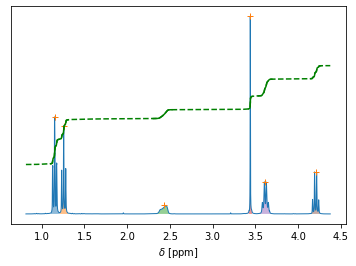

,ppm,area,est nucl.
0,1.153173,2.781046,3
1,1.258346,2.186268,2
2,2.435413,1.000000,1
3,3.440295,1.408323,1
4,3.617445,1.893583,2
5,4.205358,1.457880,1


read '..//test//testdata//nmr/magritek_1' as magritek


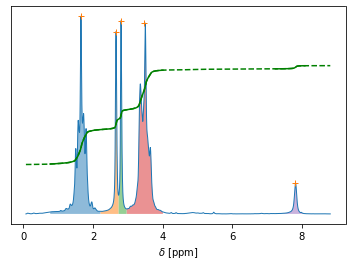

,ppm,area,est nucl.
0,1.657169,3.289311,3
1,2.661610,1.000000,1
2,2.809116,0.894505,1
3,3.476402,3.789988,4
4,7.817276,0.300314,0


In [113]:
 main()